In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model1
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		2.55483% 	6.97905% 	0.04888		0.02539		0.0		0.99997	
(1024,256) 	95.4% 		0.68738% 	6.40481% 	0.82382		0.80046		0.01812		0.88382	
(1024,1024) 	3.04% 		1.94647% 	2.28309% 	0.02452		0.00316		0.0002		0.35563	


In [8]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.88371 1.00000 0.11629 	(213910, 0.9037879560274013) 0.86636 0.90379 0.03743 	(688427, 0.938751472320377) 0.03369 0.93875 0.90506 	
(32635, 1.0) 0.85217 1.00000 0.14783 	(212974, 0.8941978001127759) 0.86390 0.89420 0.03030 	(4240, 0.9623085983510011) 0.19136 0.96231 0.77095 	
(2436, 1.0) 0.75291 1.00000 0.24709 	(44828, 0.8401417658060423) 0.81762 0.84014 0.02252 	(694929, 0.9799764428739693) 0.02392 0.97998 0.95606 	
(55808, 1.0) 0.90091 1.00000 0.09909 	(232148, 0.8783613613364569) 0.86669 0.87836 0.01168 	(600540, 0.5747938751472321) 0.03458 0.57479 0.54021 	
(44159, 1.0) 0.22060 1.00000 0.77940 	(106790, 0.8420843224691953) 0.84534 0.84208 0.00325 	(226406, 0.8680800942285042) 0.15279 0.86808 0.71529 	
(25344, 1.0) 0.94679 1.00000 0.05321 	(155900, 0.8219974944514251) 0.85551 0.82200 0.03351 	(122896, 0.99528857

(24100, 1.0) 0.10010 1.00000 0.89990 	(233729, 0.8623291476776869) 0.87015 0.86233 0.00782 	(117881, 0.8633686690223793) 0.15532 0.86337 0.70805 	
(14082, 1.0) 0.65140 1.00000 0.34860 	(78580, 0.8569978396149505) 0.84276 0.85700 0.01424 	(403835, 0.8468786808009424) 0.05877 0.84688 0.78811 	
(24330, 1.0) 0.27583 1.00000 0.72417 	(29803, 0.8613175708541942) 0.84469 0.86132 0.01663 	(333007, 0.9693757361601885) 0.05935 0.96938 0.91002 	
(17299, 1.0) 0.20499 1.00000 0.79501 	(260565, 0.8569984305801116) 0.83525 0.85700 0.02175 	(307940, 0.9081272084805654) 0.01567 0.90813 0.89246 	
(3583, 1.0) 0.79601 1.00000 0.20399 	(101553, 0.8154719704976244) 0.84809 0.81547 0.03262 	(78981, 0.6383981154299176) 0.13670 0.63840 0.50169 	
(101632, 1.0) 0.98384 1.00000 0.01616 	(109056, 0.8128818385580182) 0.79992 0.81288 0.01296 	(37897, 0.6395759717314488) 0.24412 0.63958 0.39546 	
(2813, 1.0) 0.70164 1.00000 0.29836 	(106336, 0.837155641146507) 0.85204 0.83716 0.01488 	(70064, 1.0) 0.06591 1.00000 0.9

(29450, 1.0) 0.53535 1.00000 0.46465 	(224228, 0.8935522396243347) 0.86134 0.89355 0.03221 	(170542, 0.8457008244994111) 0.04952 0.84570 0.79618 	
(29573, 1.0) 0.72957 1.00000 0.27043 	(102549, 0.8758860878860674) 0.85176 0.87589 0.02413 	(27093, 0.5759717314487633) 0.08099 0.57597 0.49498 	
(21787, 1.0) 0.21204 1.00000 0.78796 	(153666, 0.8046045106434835) 0.84333 0.80460 0.03873 	(162092, 0.9799764428739693) 0.12318 0.97998 0.85679 	
(4743, 1.0) 0.62592 1.00000 0.37408 	(234933, 0.8784704154918971) 0.86711 0.87847 0.01136 	(145806, 0.9422850412249706) 0.06237 0.94229 0.87991 	
(53387, 1.0) 0.84971 1.00000 0.15029 	(114715, 0.9620228885335768) 0.86239 0.96202 0.09963 	(433276, 0.9363957597173145) 0.05769 0.93640 0.87871 	
(64000, 1.0) 0.92663 1.00000 0.07337 	(178665, 0.8765360496630143) 0.85808 0.87654 0.01845 	(145465, 0.8445229681978799) 0.19911 0.84452 0.64541 	
(6033, 1.0) 0.18780 1.00000 0.81220 	(245587, 0.873195032251459) 0.87134 0.87320 0.00185 	(5297, 0.8386336866902238) 0.1

(21373, 1.0) 0.78074 1.00000 0.21926 	(127274, 0.848868760261584) 0.85201 0.84887 0.00314 	(2129, 0.7502944640753829) 0.16664 0.75029 0.58365 	
(39690, 1.0) 0.19384 1.00000 0.80616 	(20129, 0.8576348850484591) 0.76402 0.85763 0.09362 	(468994, 0.955241460541814) 0.17062 0.95524 0.78462 	
(12294, 1.0) 0.36378 1.00000 0.63622 	(242037, 0.8807466335552965) 0.86606 0.88075 0.01469 	(36897, 0.8928150765606597) 0.21504 0.89282 0.67778 	
(14594, 1.0) 0.71187 1.00000 0.28813 	(255224, 0.8781255823291949) 0.85778 0.87813 0.02035 	(98335, 0.795053003533569) 0.21504 0.79505 0.58002 	
(51454, 1.0) 0.99152 1.00000 0.00848 	(189378, 0.8808674492533394) 0.85607 0.88087 0.02480 	(663640, 0.9623085983510011) 0.03235 0.96231 0.92995 	
(2583, 1.0) 0.10453 1.00000 0.89547 	(64171, 0.8396305410400178) 0.85407 0.83963 0.01444 	(127740, 0.7997644287396938) 0.01608 0.79976 0.78369 	
(34820, 1.0) 0.58001 1.00000 0.41999 	(136491, 0.805306683379292) 0.85214 0.80531 0.04683 	(4432, 0.6042402826855124) 0.15928 0.

(65813, 1.0) 0.06493 1.00000 0.93507 	(44248, 0.871199908447782) 0.86130 0.87120 0.00990 	(102733, 0.9517078916372204) 0.06810 0.95171 0.88361 	
(25245, 1.0) 0.12820 1.00000 0.87180 	(57216, 0.7978017959535892) 0.85078 0.79780 0.05298 	(40019, 0.7349823321554771) 0.21504 0.73498 0.51995 	
(54746, 1.0) 0.01745 1.00000 0.98255 	(114811, 0.9631893302173906) 0.85266 0.96319 0.11053 	(68639, 0.9104829210836279) 0.21504 0.91048 0.69545 	
(68252, 1.0) 0.03357 1.00000 0.96643 	(181579, 0.8199984690282592) 0.84287 0.82000 0.02287 	(293062, 0.9752650176678446) 0.05776 0.97527 0.91751 	
(41731, 1.0) 0.26665 1.00000 0.73335 	(170180, 0.8969709515259685) 0.86943 0.89697 0.02754 	(260161, 0.9199057714958776) 0.16514 0.91991 0.75477 	
(32769, 1.0) 0.38243 1.00000 0.61757 	(82593, 0.8980708644775035) 0.84164 0.89807 0.05643 	(43225, 0.8881036513545347) 0.10715 0.88810 0.78096 	
(27518, 1.0) 0.40160 1.00000 0.59840 	(203764, 0.8599042832421685) 0.85857 0.85990 0.00133 	(7168, 0.3239104829210836) 0.2982

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
4.9064614e-08
0.999972


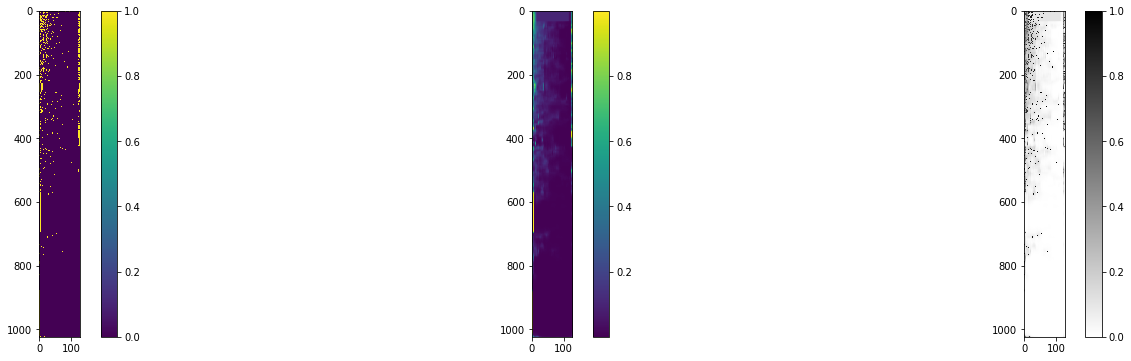

0.018121336
0.88382256


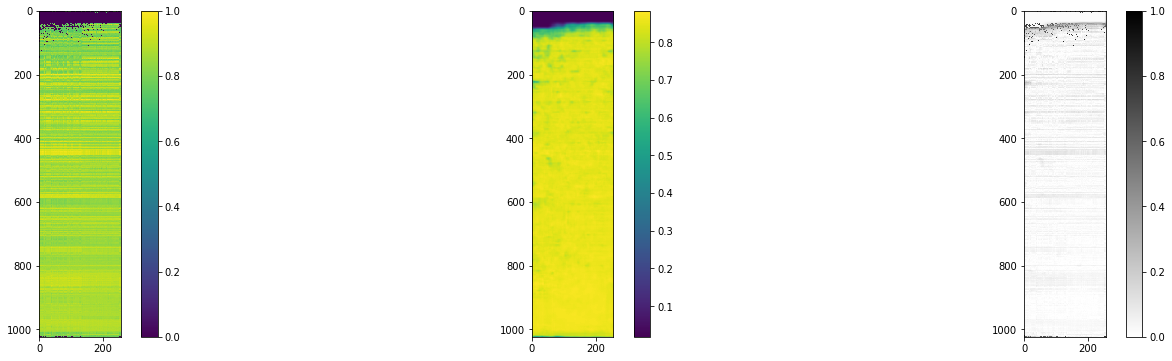

0.00020391188
0.35563266


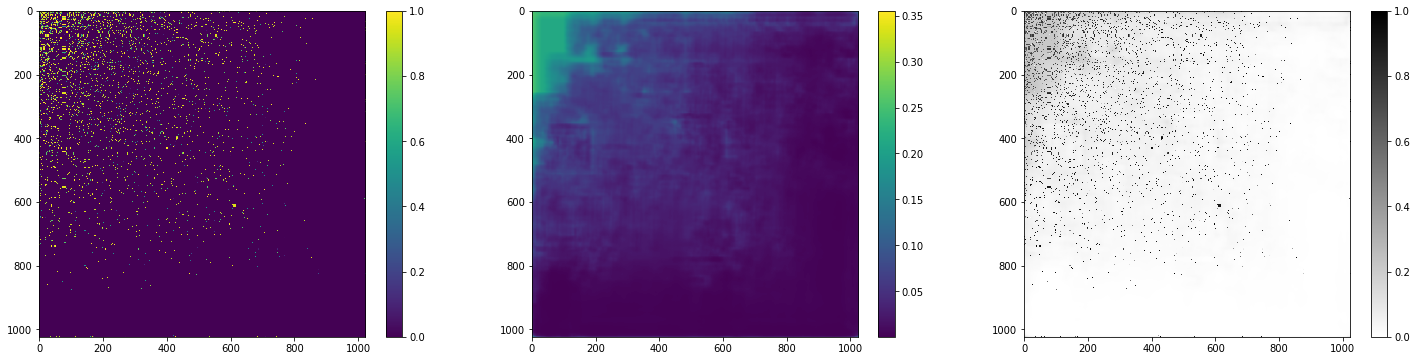

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_1_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


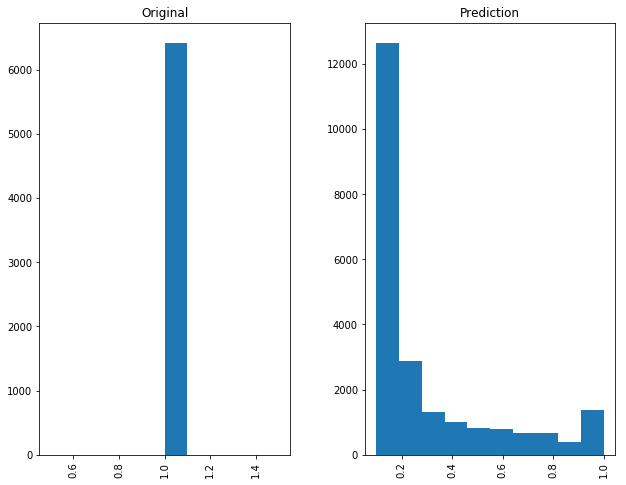

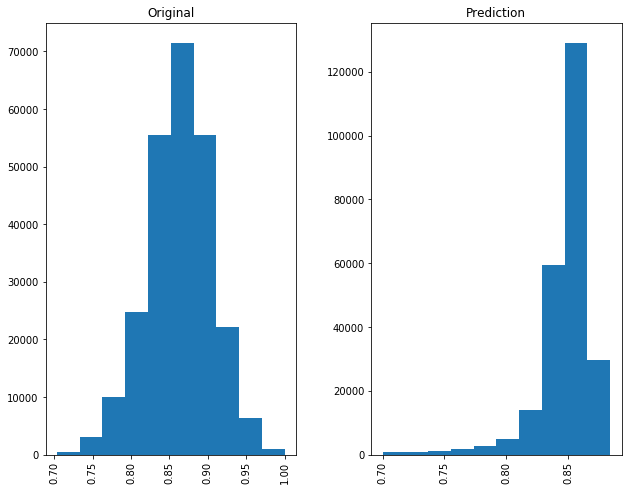

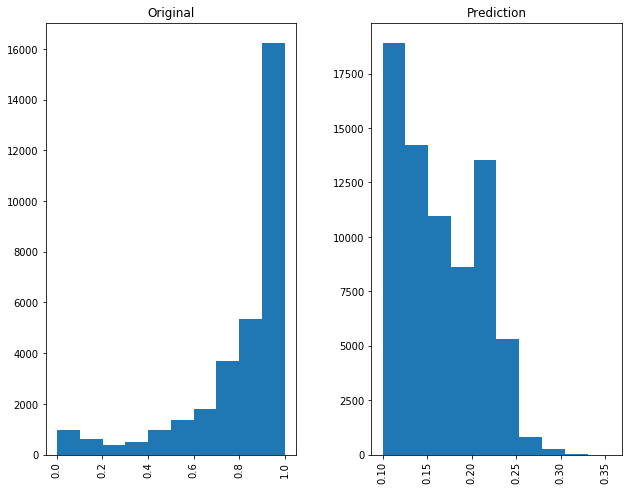

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_1_histogram_distribution_' + str(i))
    

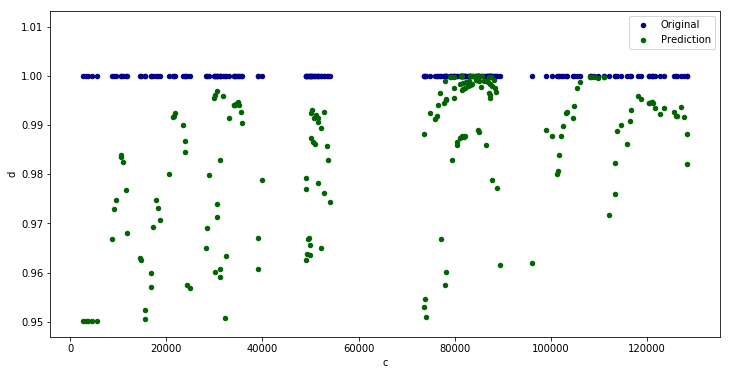

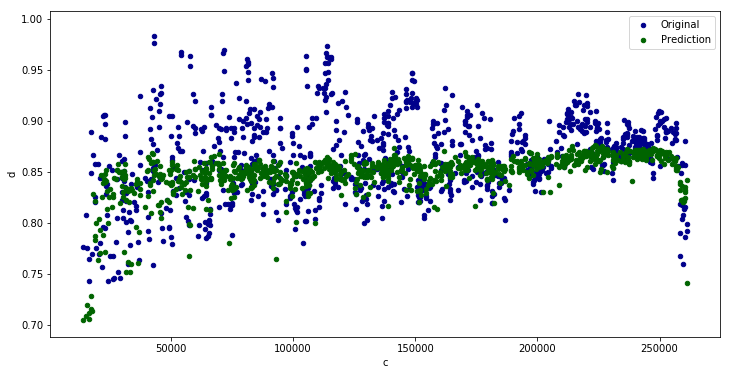

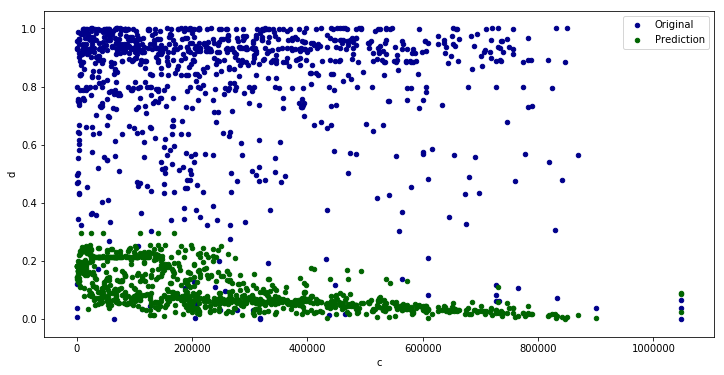

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

In [10]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		2.01213% 	6.86941% 	0.04888		0.02657		0.0		1.0	
(1024,256) 	95.4% 		0.53971% 	6.52306% 	0.82382		0.82699		0.00114		0.97369	
(1024,1024) 	3.04% 		1.90964% 	2.23623% 	0.02452		0.00268		0.0		0.32744	


In [11]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.68591 1.00000 0.31409 	(213910, 0.9037879560274013) 0.89443 0.90379 0.00935 	(688427, 0.938751472320377) 0.01347 0.93875 0.92528 	
(32635, 1.0) 0.99920 1.00000 0.00080 	(212974, 0.8941978001127759) 0.89159 0.89420 0.00261 	(4240, 0.9623085983510011) 0.26536 0.96231 0.69695 	
(2436, 1.0) 0.77037 1.00000 0.22963 	(44828, 0.8401417658060423) 0.87187 0.84014 0.03172 	(694929, 0.9799764428739693) 0.01048 0.97998 0.96950 	
(55808, 1.0) 0.63681 1.00000 0.36319 	(232148, 0.8783613613364569) 0.88209 0.87836 0.00373 	(600540, 0.5747938751472321) 0.01803 0.57479 0.55676 	
(44159, 1.0) 0.27277 1.00000 0.72723 	(106790, 0.8420843224691953) 0.85638 0.84208 0.01429 	(226406, 0.8680800942285042) 0.08291 0.86808 0.78517 	
(25344, 1.0) 0.84945 1.00000 0.15055 	(155900, 0.8219974944514251) 0.86203 0.82200 0.04004 	(122896, 0.99528857

(59523, 1.0) 0.27557 1.00000 0.72443 	(129155, 0.7999979872765527) 0.86341 0.80000 0.06341 	(183631, 0.06478209658421678) 0.06002 0.06478 0.00476 	
(57344, 1.0) 0.51030 1.00000 0.48970 	(235128, 0.8727188163808299) 0.88858 0.87272 0.01586 	(579985, 0.8833922261484101) 0.02119 0.88339 0.86220 	
(58378, 1.0) 0.04405 1.00000 0.95595 	(87579, 0.8313707011729192) 0.87513 0.83137 0.04376 	(525404, 0.9411071849234394) 0.06661 0.94111 0.87449 	
(17152, 1.0) 0.97145 1.00000 0.02855 	(71512, 0.9671947492957347) 0.89430 0.96719 0.07290 	(571684, 0.8881036513545347) 0.02154 0.88810 0.86656 	
(5505, 1.0) 0.33332 1.00000 0.66668 	(136388, 0.8390310859768031) 0.87577 0.83903 0.03674 	(700469, 0.9057714958775029) 0.03236 0.90577 0.87341 	
(1727, 1.0) 0.04772 1.00000 0.95228 	(141587, 0.9235756318547628) 0.91443 0.92358 0.00914 	(208581, 0.08362779740871625) 0.01526 0.08363 0.06837 	
(30605, 1.0) 0.99830 1.00000 0.00170 	(26153, 0.7452398860506029) 0.78499 0.74524 0.03975 	(157174, 1.0) 0.05256 1.00000

(1922, 1.0) 0.56008 1.00000 0.43992 	(256716, 0.8929296810236506) 0.88903 0.89293 0.00390 	(11464, 0.7891637220259129) 0.19308 0.78916 0.59608 	
(34944, 1.0) 0.99831 1.00000 0.00169 	(140073, 0.8372678113225259) 0.88271 0.83727 0.04544 	(279620, 0.8928150765606597) 0.08318 0.89282 0.80964 	
(4621, 1.0) 0.56869 1.00000 0.43131 	(81227, 0.9612536708339857) 0.88924 0.96125 0.07201 	(343295, 0.5053003533568905) 0.04974 0.50530 0.45556 	
(44947, 1.0) 0.76193 1.00000 0.23807 	(15515, 0.7541432834862646) 0.75643 0.75414 0.00228 	(266311, 0.2767962308598352) 0.08163 0.27680 0.19517 	
(24100, 1.0) 0.16856 1.00000 0.83144 	(233729, 0.8623291476776869) 0.88608 0.86233 0.02376 	(117881, 0.8633686690223793) 0.15695 0.86337 0.70642 	
(14082, 1.0) 0.61919 1.00000 0.38081 	(78580, 0.8569978396149505) 0.87202 0.85700 0.01503 	(403835, 0.8468786808009424) 0.04365 0.84688 0.80323 	
(24330, 1.0) 0.39432 1.00000 0.60568 	(29803, 0.8613175708541942) 0.85535 0.86132 0.00596 	(333007, 0.9693757361601885) 0.03

(3726, 1.0) 0.38667 1.00000 0.61333 	(54492, 0.8709233285418301) 0.87757 0.87092 0.00664 	(36930, 0.17432273262661965) 0.20299 0.17432 0.02866 	
(14720, 1.0) 0.93684 1.00000 0.06316 	(236889, 0.896398602496468) 0.88545 0.89640 0.01095 	(244026, 0.8904593639575972) 0.05519 0.89046 0.83527 	
(5780, 1.0) 0.21782 1.00000 0.78218 	(144519, 0.8496024406161163) 0.85774 0.84960 0.00814 	(117977, 0.8150765606595995) 0.07432 0.81508 0.74076 	
(105985, 1.0) 0.81029 1.00000 0.18971 	(121159, 0.8188181979856338) 0.87115 0.81882 0.05233 	(582333, 0.9293286219081272) 0.00769 0.92933 0.92164 	
(86016, 1.0) 1.00000 1.00000 0.00000 	(192332, 0.8975279933311768) 0.91079 0.89753 0.01326 	(293965, 0.9305064782096585) 0.07600 0.93051 0.85451 	
(39068, 1.0) 0.00738 1.00000 0.99262 	(65451, 0.8024310944854609) 0.84532 0.80243 0.04289 	(90164, 0.8939929328621907) 0.20299 0.89399 0.69101 	
(4369, 1.0) 0.26749 1.00000 0.73251 	(230983, 0.8535026070003096) 0.88042 0.85350 0.02692 	(25121, 0.9210836277974088) 0.06

(32383, 1.0) 0.99988 1.00000 0.00012 	(128595, 0.8617506791549723) 0.85071 0.86175 0.01104 	(653318, 1.0) 0.04062 1.00000 0.95938 	
(94219, 1.0) 0.03456 1.00000 0.96544 	(198166, 0.8384159289614866) 0.87928 0.83842 0.04086 	(116842, 0.6101295641931685) 0.15910 0.61013 0.45103 	
(40963, 1.0) 0.15825 1.00000 0.84175 	(243037, 0.882758693581502) 0.89054 0.88276 0.00778 	(137370, 0.9034157832744406) 0.13273 0.90342 0.77069 	
(19835, 1.0) 0.40806 1.00000 0.59194 	(62023, 0.8601789274400264) 0.87078 0.86018 0.01060 	(18460, 0.9811542991755006) 0.26386 0.98115 0.71730 	
(129280, 1.0) 0.00006 1.00000 0.99994 	(50937, 0.8313938941669136) 0.84790 0.83139 0.01651 	(446901, 0.96113074204947) 0.02970 0.96113 0.93143 	
(48128, 1.0) 0.31179 1.00000 0.68821 	(185502, 0.841465297201884) 0.87491 0.84147 0.03344 	(3603, 0.7361601884570083) 0.07549 0.73616 0.66067 	
(48522, 1.0) 0.78851 1.00000 0.21149 	(217997, 0.8950593016451204) 0.88679 0.89506 0.00827 	(468655, 0.9964664310954064) 0.00924 0.99647 0.98

(534, 1.0) 0.10470 1.00000 0.89530 	(137695, 0.8633334436393306) 0.90051 0.86333 0.03718 	(564698, 0.36866902237926985) 0.01489 0.36867 0.35378 	
(58373, 1.0) 0.70707 1.00000 0.29293 	(259163, 0.8174080355227247) 0.81952 0.81741 0.00211 	(104695, 0.977620730270907) 0.07569 0.97762 0.90193 	
(8193, 1.0) 0.28671 1.00000 0.71329 	(175764, 0.8656188197498577) 0.87740 0.86562 0.01179 	(640284, 0.9363957597173145) 0.01334 0.93640 0.92305 	
(91397, 1.0) 0.99913 1.00000 0.00087 	(140329, 0.9288307329111433) 0.88130 0.92883 0.04753 	(734568, 0.8904593639575972) 0.01036 0.89046 0.88010 	
(47491, 1.0) 0.98287 1.00000 0.01713 	(255507, 0.8895527033759333) 0.90405 0.88955 0.01450 	(450326, 0.9375736160188458) 0.00298 0.93757 0.93459 	
(23817, 1.0) 0.25933 1.00000 0.74067 	(248701, 0.9042644236060254) 0.88490 0.90426 0.01936 	(243864, 0.34275618374558303) 0.04864 0.34276 0.29411 	
(23434, 1.0) 0.04360 1.00000 0.95640 	(117161, 0.8381221871325827) 0.88102 0.83812 0.04289 	(310390, 0.49469964664310956

(9855, 1.0) 0.92253 1.00000 0.07747 	(123787, 0.8442056790026061) 0.88028 0.84421 0.03607 	(522442, 0.9340400471142521) 0.03809 0.93404 0.89595 	
(38142, 1.0) 0.77561 1.00000 0.22439 	(242387, 0.8730593950976218) 0.88534 0.87306 0.01228 	(565325, 0.9458186101295644) 0.06564 0.94582 0.88018 	
(8957, 1.0) 0.69067 1.00000 0.30933 	(105274, 0.9515216253790182) 0.87339 0.95152 0.07813 	(107091, 0.7314487632508835) 0.03501 0.73145 0.69644 	
(81026, 1.0) 0.99994 1.00000 0.00006 	(44919, 0.9098960912587629) 0.86388 0.90990 0.04602 	(735517, 0.955241460541814) 0.00605 0.95524 0.94920 	
(32255, 1.0) 0.99974 1.00000 0.00026 	(43113, 0.9763637370973544) 0.87875 0.97636 0.09761 	(2189, 0.9893992932862191) 0.23402 0.98940 0.75538 	
(35713, 1.0) 0.38515 1.00000 0.61485 	(151551, 0.8292277679913906) 0.85194 0.82923 0.02271 	(23, 0.12014134275618375) 0.17446 0.12014 0.05432 	
(4884, 1.0) 0.22538 1.00000 0.77462 	(253601, 0.8906563534851561) 0.88242 0.89066 0.00823 	(326962, 0.9988221436984688) 0.06813 

(54655, 1.0) 0.45737 1.00000 0.54263 	(21246, 0.8840065845222049) 0.84640 0.88401 0.03761 	(135207, 0.9988221436984688) 0.19971 0.99882 0.79911 	
(79747, 1.0) 0.99989 1.00000 0.00011 	(138584, 0.8965568443175121) 0.89976 0.89656 0.00320 	(288224, 0.9988221436984688) 0.02236 0.99882 0.97646 	
(27135, 1.0) 0.62031 1.00000 0.37969 	(112877, 0.9206918058369541) 0.93243 0.92069 0.01174 	(38136, 0.9069493521790342) 0.07859 0.90695 0.82836 	
(42116, 1.0) 0.50879 1.00000 0.49121 	(224729, 0.8985757531364934) 0.88198 0.89858 0.01660 	(38974, 0.8127208480565372) 0.20299 0.81272 0.60974 	
(4354, 1.0) 0.25832 1.00000 0.74168 	(183763, 0.8461148673942293) 0.87061 0.84611 0.02450 	(391277, 0.9575971731448765) 0.03714 0.95760 0.92046 	
(5378, 1.0) 0.50817 1.00000 0.49183 	(42202, 0.9044876771971088) 0.88238 0.90449 0.02210 	(230833, 0.9305064782096585) 0.03115 0.93051 0.89935 	
(773, 1.0) 0.53635 1.00000 0.46365 	(51896, 0.844459428175284) 0.87012 0.84446 0.02566 	(380650, 0.8904593639575972) 0.00466

(87043, 1.0) 1.00000 1.00000 0.00000 	(94688, 0.8929694493960458) 0.86280 0.89297 0.03017 	(258632, 0.9281507656065962) 0.00939 0.92815 0.91877 	
(14094, 1.0) 0.19505 1.00000 0.80495 	(85187, 0.9055170036723605) 0.87895 0.90552 0.02657 	(159893, 0.9693757361601885) 0.13674 0.96938 0.83264 	
(84866, 1.0) 0.99816 1.00000 0.00184 	(245900, 0.8722292442600549) 0.88662 0.87223 0.01439 	(11459, 0.9835100117785631) 0.20342 0.98351 0.78009 	
(5520, 1.0) 0.18813 1.00000 0.81187 	(42541, 0.9308639356915954) 0.86864 0.93086 0.06223 	(501492, 0.6713780918727915) 0.00413 0.67138 0.66725 	
(116737, 1.0) 1.00000 1.00000 0.00000 	(239783, 0.8718906587529215) 0.88528 0.87189 0.01339 	(179261, 0.9375736160188458) 0.12122 0.93757 0.81635 	
(3601, 1.0) 0.21226 1.00000 0.78774 	(50089, 0.8852176152437102) 0.86942 0.88522 0.01580 	(227361, 0.9540636042402827) 0.12542 0.95406 0.82865 	
(10624, 1.0) 0.99010 1.00000 0.00990 	(122362, 0.9056083861577233) 0.87297 0.90561 0.03264 	(7373, 0.8433451118963486) 0.212

(27284, 1.0) 0.30905 1.00000 0.69095 	(236541, 0.8968312679496214) 0.88451 0.89683 0.01233 	(755751, 0.9988221436984688) 0.02691 0.99882 0.97191 	
(97423, 1.0) 0.86519 1.00000 0.13481 	(106538, 0.894393269998844) 0.85236 0.89439 0.04203 	(230831, 0.9305064782096585) 0.03096 0.93051 0.89955 	
(48897, 1.0) 0.79098 1.00000 0.20902 	(113790, 0.9733947675958406) 0.95092 0.97339 0.02248 	(868912, 0.5665488810365136) 0.00491 0.56655 0.56164 	
(113793, 1.0) 1.00000 1.00000 0.00000 	(49410, 0.7956718475747022) 0.78192 0.79567 0.01376 	(51766, 0.9988221436984688) 0.03698 0.99882 0.96184 	
(24342, 1.0) 0.37923 1.00000 0.62077 	(17420, 0.7563035891312273) 0.54523 0.75630 0.21107 	(289885, 0.7773851590106008) 0.05982 0.77739 0.71757 	
(26511, 1.0) 0.11066 1.00000 0.88934 	(53460, 0.83468955915907) 0.87182 0.83469 0.03713 	(220310, 0.850412249705536) 0.06134 0.85041 0.78907 	
(103042, 1.0) 0.98174 1.00000 0.01826 	(179325, 0.8734828094900088) 0.86936 0.87348 0.00412 	(17709, 0.9846878680800943) 0.13

(56981, 1.0) 0.34674 1.00000 0.65326 	(94081, 0.8582202106983956) 0.86753 0.85822 0.00931 	(196727, 0.5147232037691402) 0.13918 0.51472 0.37554 	
(31131, 1.0) 0.99818 1.00000 0.00182 	(101681, 0.8941588533045163) 0.87893 0.89416 0.01523 	(48, 0.9316843345111897) 0.17218 0.93168 0.75951 	
(113281, 1.0) 1.00000 1.00000 0.00000 	(31402, 0.8993755226643444) 0.85574 0.89938 0.04364 	(165176, 0.6383981154299176) 0.08325 0.63840 0.55515 	
(25087, 1.0) 0.69832 1.00000 0.30168 	(181779, 0.8506879794512554) 0.88350 0.85069 0.03281 	(269409, 0.9305064782096585) 0.06503 0.93051 0.86548 	
(29075, 1.0) 0.33842 1.00000 0.66158 	(254817, 0.893556379087391) 0.89030 0.89356 0.00326 	(306733, 0.9305064782096585) 0.01376 0.93051 0.91674 	
(15123, 1.0) 0.30733 1.00000 0.69267 	(147373, 0.8332600739307525) 0.88520 0.83326 0.05194 	(609450, 0.082449941107185) 0.01755 0.08245 0.06490 	
(74116, 1.0) 0.97860 1.00000 0.02140 	(59363, 0.8424650055172322) 0.88805 0.84247 0.04559 	(572420, 0.7550058892815077) 0.022

(98179, 1.0) 0.46086 1.00000 0.53914 	(137060, 0.8996582690308821) 0.86680 0.89966 0.03285 	(727634, 0.06360424028268553) 0.01469 0.06360 0.04891 	
(65813, 1.0) 0.12340 1.00000 0.87660 	(44248, 0.871199908447782) 0.90586 0.87120 0.03466 	(102733, 0.9517078916372204) 0.04942 0.95171 0.90229 	
(25245, 1.0) 0.17843 1.00000 0.82157 	(57216, 0.7978017959535892) 0.85643 0.79780 0.05863 	(40019, 0.7349823321554771) 0.20299 0.73498 0.53200 	
(54746, 1.0) 0.07161 1.00000 0.92839 	(114811, 0.9631893302173906) 0.94029 0.96319 0.02290 	(68639, 0.9104829210836279) 0.20299 0.91048 0.70750 	
(68252, 1.0) 0.18116 1.00000 0.81884 	(181579, 0.8199984690282592) 0.86807 0.82000 0.04807 	(293062, 0.9752650176678446) 0.02520 0.97527 0.95007 	
(41731, 1.0) 0.75631 1.00000 0.24369 	(170180, 0.8969709515259685) 0.88581 0.89697 0.01116 	(260161, 0.9199057714958776) 0.08097 0.91991 0.83894 	
(32769, 1.0) 0.55431 1.00000 0.44569 	(82593, 0.8980708644775035) 0.90188 0.89807 0.00381 	(43225, 0.8881036513545347) 0.0

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
1.248494e-32
1.0


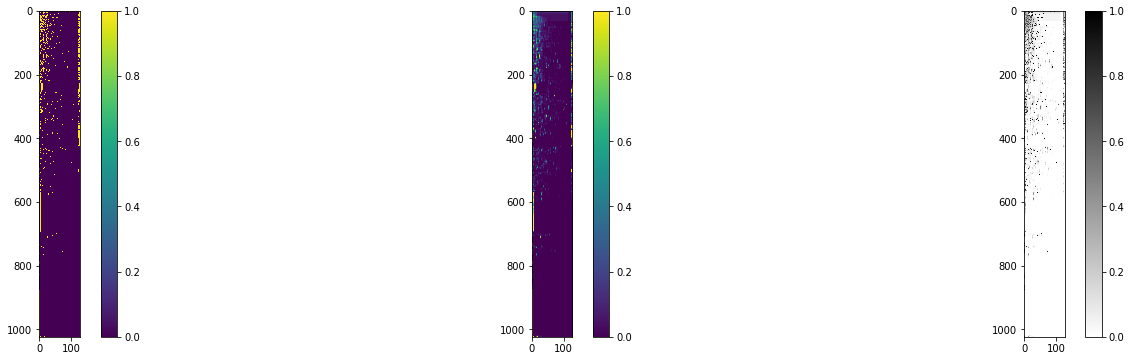

0.0011435994
0.9736876


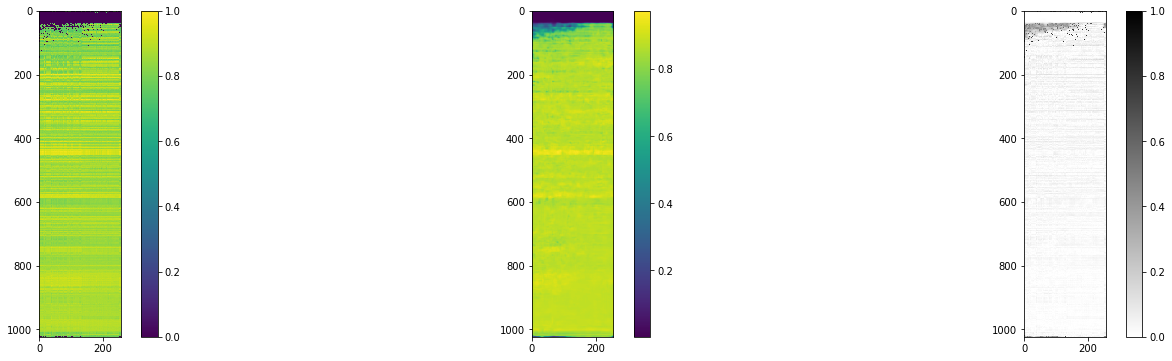

1.0998177e-07
0.32744315


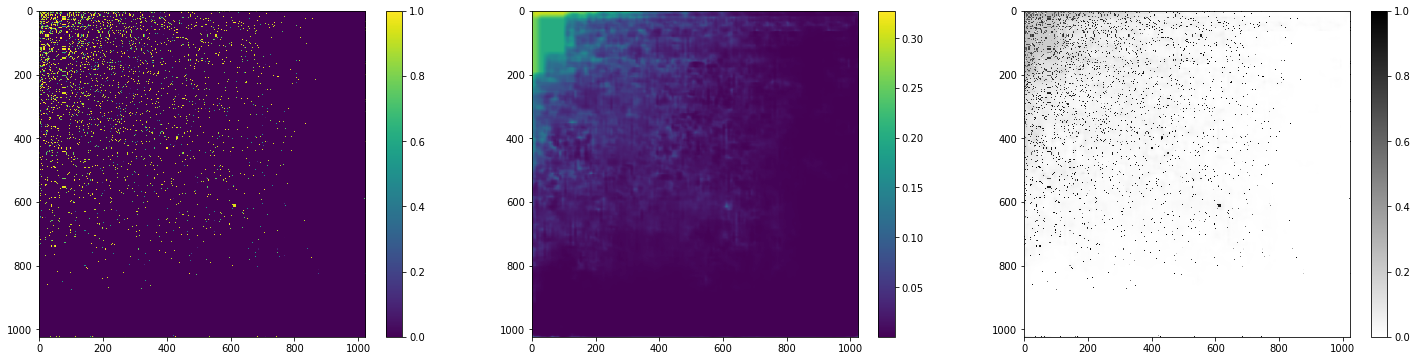

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_2_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


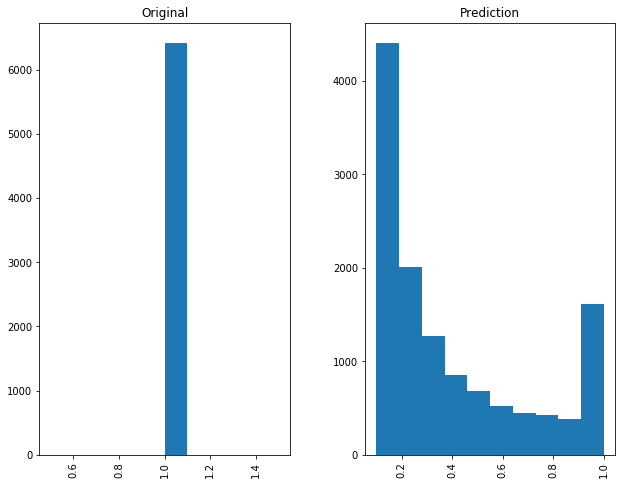

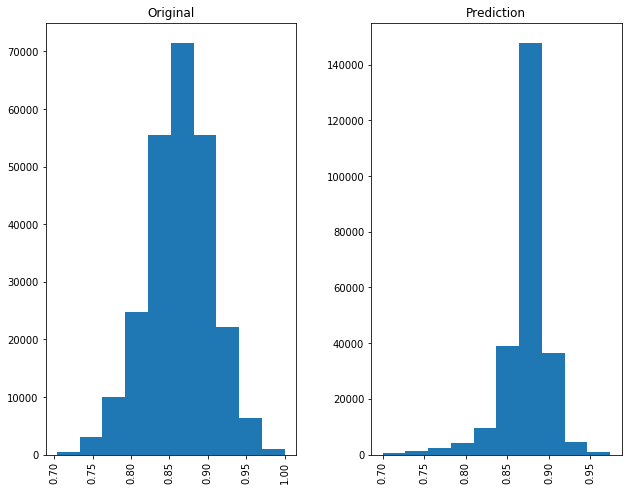

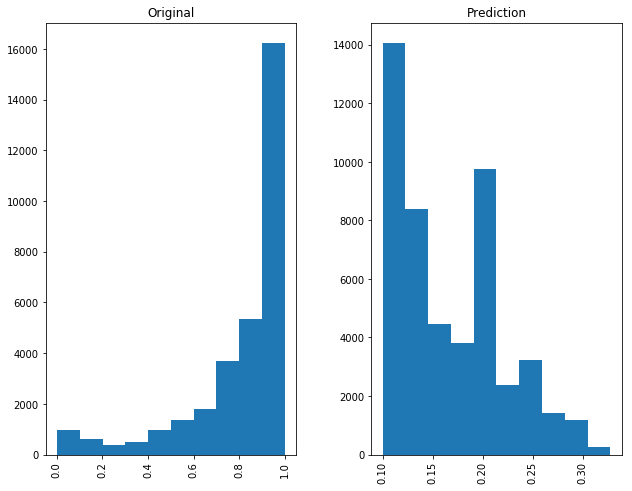

In [13]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_2_histogram_distribution_' + str(i))
    

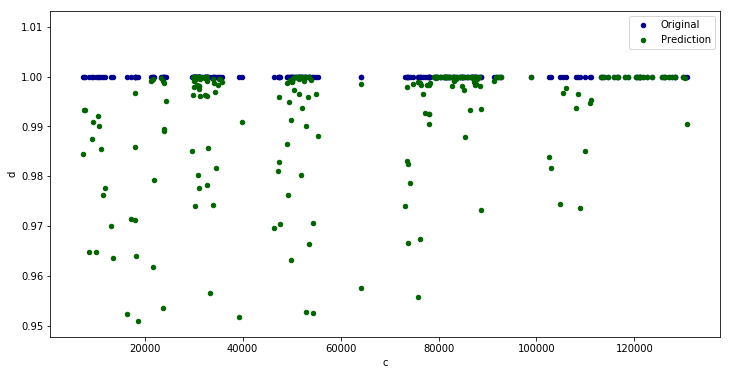

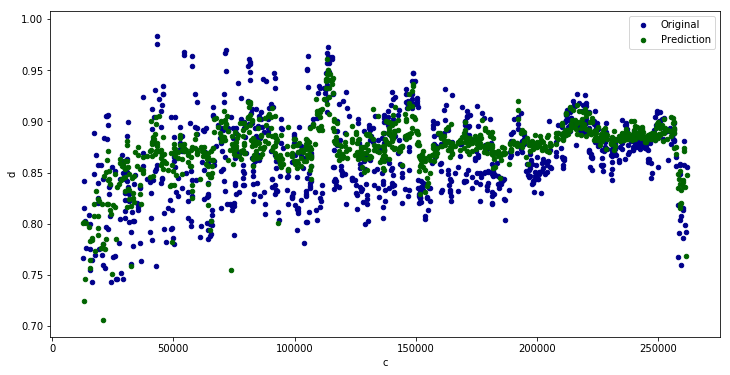

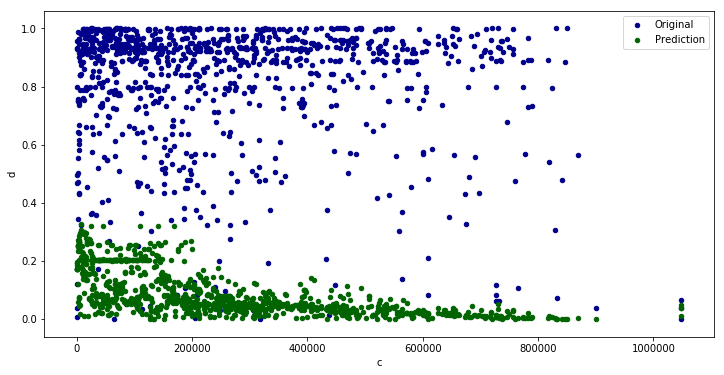

In [14]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

In [15]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.79068% 	8.34114% 	0.04888		0.04011		0.0		1.0	
(1024,256) 	95.4% 		0.50732% 	6.44326% 	0.82382		0.8045		0.0		0.97518	
(1024,1024) 	3.04% 		1.90246% 	2.32657% 	0.02452		0.00356		0.0		0.44823	


In [16]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.99992 1.00000 0.00008 	(213910, 0.9037879560274013) 0.88356 0.90379 0.02023 	(688427, 0.938751472320377) 0.02488 0.93875 0.91388 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.86680 0.89420 0.02740 	(4240, 0.9623085983510011) 0.30329 0.96231 0.65902 	
(2436, 1.0) 0.94568 1.00000 0.05432 	(44828, 0.8401417658060423) 0.85330 0.84014 0.01316 	(694929, 0.9799764428739693) 0.03225 0.97998 0.94773 	
(55808, 1.0) 0.77946 1.00000 0.22054 	(232148, 0.8783613613364569) 0.85764 0.87836 0.02072 	(600540, 0.5747938751472321) 0.02899 0.57479 0.54580 	
(44159, 1.0) 0.54601 1.00000 0.45399 	(106790, 0.8420843224691953) 0.84699 0.84208 0.00491 	(226406, 0.8680800942285042) 0.08481 0.86808 0.78327 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.82155 0.82200 0.00045 	(122896, 0.99528857

(25105, 1.0) 0.99412 1.00000 0.00588 	(83215, 0.8801234976685764) 0.86774 0.88012 0.01238 	(609364, 0.9493521790341579) 0.02627 0.94935 0.92308 	
(20779, 1.0) 0.99997 1.00000 0.00003 	(22918, 0.9065176667814063) 0.82686 0.90652 0.07966 	(660654, 0.8869257950530036) 0.02841 0.88693 0.85852 	
(2580, 1.0) 0.68372 1.00000 0.31628 	(81452, 0.9560840745164847) 0.89571 0.95608 0.06037 	(253066, 0.9646643109540636) 0.08516 0.96466 0.87951 	
(46219, 1.0) 0.89149 1.00000 0.10851 	(62612, 0.8908013524590833) 0.84956 0.89080 0.04124 	(146651, 0.9128386336866903) 0.07406 0.91284 0.83878 	
(58659, 1.0) 0.13916 1.00000 0.86084 	(118434, 0.9174479285497729) 0.84450 0.91745 0.07294 	(272646, 0.8138987043580682) 0.06508 0.81390 0.74881 	
(11156, 1.0) 0.41399 1.00000 0.58601 	(89238, 0.8931446765002358) 0.87505 0.89314 0.01810 	(483510, 0.9681978798586572) 0.07961 0.96820 0.88859 	
(8712, 1.0) 0.87252 1.00000 0.12748 	(222790, 0.8651861688749861) 0.86989 0.86519 0.00471 	(207996, 0.9316843345111897) 0.11

(3839, 1.0) 0.83504 1.00000 0.16496 	(55978, 0.8054739150457626) 0.84580 0.80547 0.04032 	(727709, 0.7997644287396938) 0.02361 0.79976 0.77616 	
(15116, 1.0) 0.63898 1.00000 0.36102 	(24623, 0.855467495134205) 0.75908 0.85547 0.09639 	(15481, 0.9952885747938752) 0.26240 0.99529 0.73288 	
(20254, 1.0) 0.76681 1.00000 0.23319 	(123773, 0.8448526991305813) 0.86194 0.84485 0.01709 	(196964, 0.9505300353356891) 0.06490 0.95053 0.88563 	
(18046, 1.0) 1.00000 1.00000 0.00000 	(88910, 0.9025126822120522) 0.84286 0.90251 0.05966 	(414924, 0.8457008244994111) 0.04058 0.84570 0.80512 	
(33283, 1.0) 1.00000 1.00000 0.00000 	(48003, 0.815085237445458) 0.82272 0.81509 0.00763 	(466988, 0.9281507656065962) 0.06141 0.92815 0.86674 	
(27133, 1.0) 0.99950 1.00000 0.00050 	(133018, 0.9051239729466295) 0.85922 0.90512 0.04590 	(56017, 0.9988221436984688) 0.02957 0.99882 0.96925 	
(60328, 1.0) 0.13982 1.00000 0.86018 	(226091, 0.8837821244094075) 0.85898 0.88378 0.02480 	(220230, 0.9458186101295644) 0.1187

(35620, 1.0) 0.09681 1.00000 0.90319 	(118628, 0.8815716731699286) 0.84280 0.88157 0.03877 	(540199, 0.751472320376914) 0.06532 0.75147 0.68615 	
(24575, 1.0) 0.99985 1.00000 0.00015 	(117573, 0.8911461389350012) 0.86344 0.89115 0.02771 	(42743, 0.7302709069493521) 0.04640 0.73027 0.68387 	
(26783, 1.0) 0.23772 1.00000 0.76228 	(178054, 0.8493597952574691) 0.84236 0.84936 0.00700 	(141336, 0.7455830388692579) 0.25503 0.74558 0.49056 	
(103168, 1.0) 1.00000 1.00000 0.00000 	(256515, 0.881082260643664) 0.85002 0.88108 0.03106 	(2128, 0.7502944640753829) 0.29782 0.75029 0.45247 	
(45955, 1.0) 0.99993 1.00000 0.00007 	(22217, 0.9052185526877297) 0.83914 0.90522 0.06607 	(277907, 0.9658421672555949) 0.08396 0.96584 0.88188 	
(34174, 1.0) 1.00000 1.00000 0.00000 	(45905, 0.9343640159591515) 0.83970 0.93436 0.09466 	(219183, 0.8598351001177857) 0.18034 0.85984 0.67950 	
(11536, 1.0) 0.46145 1.00000 0.53855 	(139018, 0.83485313714037) 0.85545 0.83485 0.02059 	(387345, 0.9210836277974088) 0.083

(1925, 1.0) 0.85573 1.00000 0.14427 	(141188, 0.8301495036514918) 0.86161 0.83015 0.03146 	(152579, 0.5041224970553593) 0.30998 0.50412 0.19414 	
(19480, 1.0) 0.81776 1.00000 0.18224 	(212005, 0.9018585526255439) 0.89825 0.90186 0.00361 	(276779, 0.7997644287396938) 0.08578 0.79976 0.71399 	
(53756, 1.0) 1.00000 1.00000 0.00000 	(171010, 0.9058133675469068) 0.84403 0.90581 0.06179 	(122102, 0.45818610129564197) 0.09911 0.45819 0.35908 	
(3234, 1.0) 0.12997 1.00000 0.87003 	(248856, 0.8813804499088315) 0.85982 0.88138 0.02156 	(95280, 0.889281507656066) 0.22925 0.88928 0.66003 	
(73728, 1.0) 1.00000 1.00000 0.00000 	(226775, 0.8645351109824827) 0.86225 0.86454 0.00228 	(191991, 0.9352179034157833) 0.02132 0.93522 0.91390 	
(40094, 1.0) 0.96124 1.00000 0.03876 	(210625, 0.8863205916304487) 0.86458 0.88632 0.02174 	(210966, 0.9988221436984688) 0.17599 0.99882 0.82284 	
(62263, 1.0) 0.87329 1.00000 0.12671 	(56059, 0.8306070617555773) 0.82803 0.83061 0.00258 	(187551, 0.10836277974087162) 

(89728, 1.0) 1.00000 1.00000 0.00000 	(196432, 0.8477723666994413) 0.84837 0.84777 0.00060 	(16681, 0.9246171967020024) 0.15101 0.92462 0.77361 	
(4738, 1.0) 0.42723 1.00000 0.57277 	(162062, 0.9323094589311655) 0.85854 0.93231 0.07377 	(167936, 0.9281507656065962) 0.35461 0.92815 0.57354 	
(39316, 1.0) 0.99653 1.00000 0.00347 	(254018, 0.8627213398826145) 0.84549 0.86272 0.01723 	(145511, 0.8657243816254419) 0.14428 0.86572 0.72145 	
(126977, 1.0) 1.00000 1.00000 0.00000 	(144408, 0.8562474300935635) 0.84945 0.85625 0.00680 	(104535, 0.96113074204947) 0.22925 0.96113 0.73188 	
(53381, 1.0) 1.00000 1.00000 0.00000 	(34221, 0.847709794418642) 0.84412 0.84771 0.00359 	(310304, 0.9705535924617197) 0.15381 0.97055 0.81674 	
(11519, 1.0) 0.99124 1.00000 0.00876 	(13034, 0.8413900033969399) 0.77804 0.84139 0.06335 	(67857, 0.8150765606595995) 0.10482 0.81508 0.71026 	
(23935, 1.0) 1.00000 1.00000 0.00000 	(63884, 0.8006484402889107) 0.81418 0.80065 0.01353 	(202904, 0.9717314487632509) 0.053

(129921, 1.0) 1.00000 1.00000 0.00000 	(42822, 0.7588843823223201) 0.86066 0.75888 0.10177 	(84196, 0.92226148409894) 0.09861 0.92226 0.82365 	
(12671, 1.0) 0.99999 1.00000 0.00001 	(261373, 0.7917948910537543) 0.74146 0.79179 0.05034 	(70842, 0.9458186101295644) 0.13501 0.94582 0.81081 	
(70918, 1.0) 0.22065 1.00000 0.77935 	(201581, 0.8300839268039246) 0.84019 0.83008 0.01011 	(4241, 0.9623085983510011) 0.30304 0.96231 0.65926 	
(20493, 1.0) 0.10153 1.00000 0.89847 	(185007, 0.8389086283169533) 0.84560 0.83891 0.00669 	(383200, 0.8939929328621907) 0.05908 0.89399 0.83491 	
(4615, 1.0) 0.78318 1.00000 0.21682 	(105089, 0.8015273975526116) 0.86380 0.80153 0.06227 	(344194, 0.9740871613663132) 0.09591 0.97409 0.87818 	
(78208, 1.0) 1.00000 1.00000 0.00000 	(181594, 0.8313319908016144) 0.83289 0.83133 0.00156 	(11483, 0.8833922261484101) 0.15621 0.88339 0.72718 	
(11008, 1.0) 0.99998 1.00000 0.00002 	(226981, 0.8566625346847325) 0.86383 0.85666 0.00716 	(24576, 0.36277974087161374) 0.355

(127745, 1.0) 1.00000 1.00000 0.00000 	(179993, 0.8515489276398169) 0.86382 0.85155 0.01227 	(198150, 0.4994110718492344) 0.02695 0.49941 0.47246 	
(25415, 1.0) 0.97244 1.00000 0.02756 	(175409, 0.9156561570916643) 0.85379 0.91566 0.06187 	(199688, 0.9988221436984688) 0.27976 0.99882 0.71906 	
(3204, 1.0) 0.52904 1.00000 0.47096 	(66930, 0.8611952742911493) 0.88276 0.86120 0.02156 	(82973, 0.9988221436984688) 0.23411 0.99882 0.76471 	
(258, 1.0) 0.56864 1.00000 0.43136 	(32418, 0.7914176499394617) 0.79752 0.79142 0.00610 	(374080, 0.9269729093050648) 0.04289 0.92697 0.88408 	
(87300, 1.0) 1.00000 1.00000 0.00000 	(231712, 0.8740718142169187) 0.86480 0.87407 0.00928 	(181452, 0.6383981154299176) 0.08469 0.63840 0.55371 	
(1694, 1.0) 0.05454 1.00000 0.94546 	(28015, 0.8047441309420261) 0.82219 0.80474 0.01745 	(609111, 0.2096584216725559) 0.00290 0.20966 0.20675 	
(7261, 1.0) 0.99614 1.00000 0.00386 	(194768, 0.8829893599177296) 0.85743 0.88299 0.02556 	(546928, 1.0) 0.05682 1.00000 0.94

(87424, 1.0) 1.00000 1.00000 0.00000 	(116177, 0.8549689190548719) 0.84970 0.85497 0.00527 	(55421, 0.7820965842167256) 0.22497 0.78210 0.55713 	
(21373, 1.0) 1.00000 1.00000 0.00000 	(127274, 0.848868760261584) 0.83489 0.84887 0.01398 	(2129, 0.7502944640753829) 0.29782 0.75029 0.45247 	
(39690, 1.0) 0.95159 1.00000 0.04841 	(20129, 0.8576348850484591) 0.80365 0.85763 0.05398 	(468994, 0.955241460541814) 0.11726 0.95524 0.83798 	
(12294, 1.0) 0.88025 1.00000 0.11975 	(242037, 0.8807466335552965) 0.86505 0.88075 0.01570 	(36897, 0.8928150765606597) 0.22925 0.89282 0.66356 	
(14594, 1.0) 0.98338 1.00000 0.01662 	(255224, 0.8781255823291949) 0.86393 0.87813 0.01420 	(98335, 0.795053003533569) 0.22925 0.79505 0.56580 	
(51454, 1.0) 1.00000 1.00000 0.00000 	(189378, 0.8808674492533394) 0.84111 0.88087 0.03976 	(663640, 0.9623085983510011) 0.03187 0.96231 0.93044 	
(2583, 1.0) 0.66763 1.00000 0.33237 	(64171, 0.8396305410400178) 0.81966 0.83963 0.01997 	(127740, 0.7997644287396938) 0.00517 

(18958, 1.0) 0.99530 1.00000 0.00470 	(243605, 0.8774189622639483) 0.86249 0.87742 0.01492 	(52259, 0.9269729093050648) 0.22925 0.92697 0.69772 	
(87428, 1.0) 1.00000 1.00000 0.00000 	(138873, 0.8977764604825018) 0.85767 0.89778 0.04011 	(26786, 0.6619552414605419) 0.19089 0.66196 0.47107 	
(36479, 1.0) 0.96512 1.00000 0.03488 	(66901, 0.8572107203099771) 0.87642 0.85721 0.01921 	(56370, 0.9988221436984688) 0.22925 0.99882 0.76957 	
(18566, 1.0) 0.84988 1.00000 0.15012 	(115322, 0.9633116458814829) 0.93419 0.96331 0.02913 	(26705, 1.0) 0.25513 1.00000 0.74487 	
(7429, 1.0) 0.97989 1.00000 0.02011 	(181294, 0.8267100985764247) 0.83126 0.82671 0.00455 	(51332, 0.9988221436984688) 0.20916 0.99882 0.78966 	
(74242, 1.0) 1.00000 1.00000 0.00000 	(13885, 0.7940061024166285) 0.58752 0.79401 0.20649 	(233562, 1.0) 0.08647 1.00000 0.91353 	
(17154, 1.0) 0.99969 1.00000 0.00031 	(19069, 0.8577007729418251) 0.82882 0.85770 0.02888 	(476582, 0.9681978798586572) 0.03684 0.96820 0.93136 	
(62080, 1.

(2193, 1.0) 0.21310 1.00000 0.78690 	(165182, 0.9260564185888208) 0.84828 0.92606 0.07777 	(390524, 0.7302709069493521) 0.08187 0.73027 0.64840 	
(6663, 1.0) 0.98731 1.00000 0.01269 	(222390, 0.8651999222012362) 0.86142 0.86520 0.00378 	(153163, 0.9328621908127209) 0.02981 0.93286 0.90305 	
(42240, 1.0) 0.99798 1.00000 0.00202 	(30116, 0.8437491417362486) 0.83293 0.84375 0.01082 	(158958, 0.8386336866902238) 0.12193 0.83863 0.71670 	
(91034, 1.0) 1.00000 1.00000 0.00000 	(228742, 0.873035767853537) 0.86117 0.87304 0.01186 	(239994, 0.1107184923439341) 0.06350 0.11072 0.04722 	
(27674, 1.0) 0.28227 1.00000 0.71773 	(221653, 0.8723428752082522) 0.87110 0.87234 0.00124 	(4301, 0.9623085983510011) 0.27580 0.96231 0.68651 	
(4734, 1.0) 0.97927 1.00000 0.02073 	(248212, 0.8920951409612782) 0.86652 0.89210 0.02558 	(47284, 0.9705535924617197) 0.12155 0.97055 0.84900 	
(782, 1.0) 0.56723 1.00000 0.43277 	(18875, 0.8250735102522675) 0.77402 0.82507 0.05105 	(187495, 0.9658421672555949) 0.15074 

(46877, 1.0) 0.43257 1.00000 0.56743 	(65178, 0.7874688920173168) 0.80691 0.78747 0.01944 	(246302, 0.8869257950530036) 0.08416 0.88693 0.80276 	
(33022, 1.0) 1.00000 1.00000 0.00000 	(225786, 0.8826802938576508) 0.86243 0.88268 0.02025 	(415373, 0.9988221436984688) 0.07811 0.99882 0.92071 	
(15235, 1.0) 0.84235 1.00000 0.15765 	(191652, 0.868715650240178) 0.85472 0.86872 0.01400 	(103819, 0.9469964664310954) 0.05150 0.94700 0.89549 	
(15506, 1.0) 0.99590 1.00000 0.00410 	(151641, 0.8253741727779265) 0.83467 0.82537 0.00929 	(536622, 0.9599528857479388) 0.04216 0.95995 0.91780 	
(13181, 1.0) 0.99999 1.00000 0.00001 	(218687, 0.9106961520087443) 0.86866 0.91070 0.04203 	(396334, 0.9528857479387515) 0.14274 0.95289 0.81015 	
(6655, 1.0) 0.99548 1.00000 0.00452 	(14691, 0.8487331979469075) 0.64448 0.84873 0.20425 	(213272, 0.92226148409894) 0.05999 0.92226 0.86227 	
(8461, 1.0) 0.29090 1.00000 0.70910 	(46085, 0.8101512085909478) 0.84760 0.81015 0.03745 	(398977, 0.9199057714958776) 0.020

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


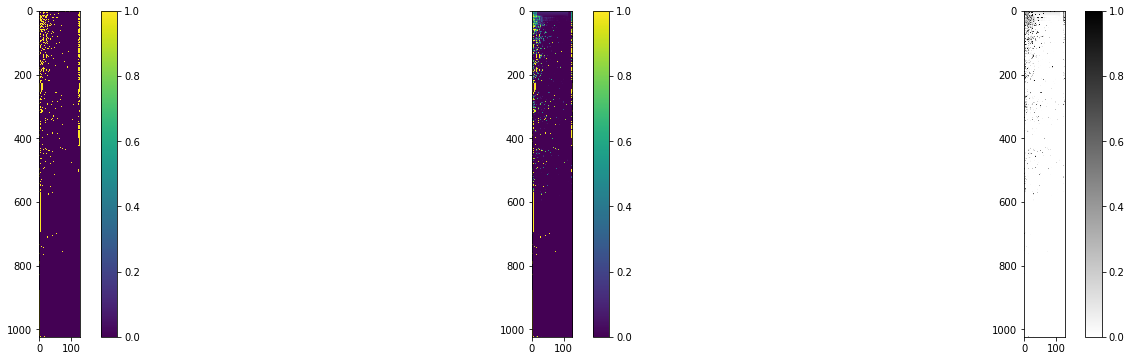

1.984671e-06
0.9751796


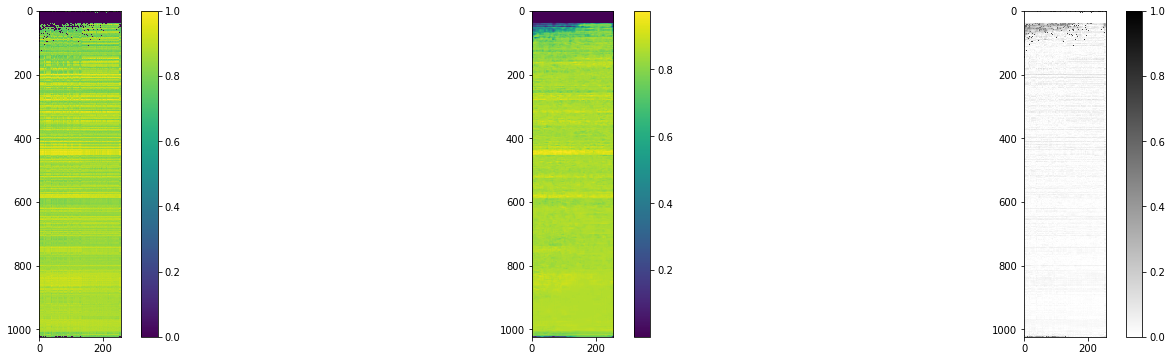

1.5611316e-09
0.44822767


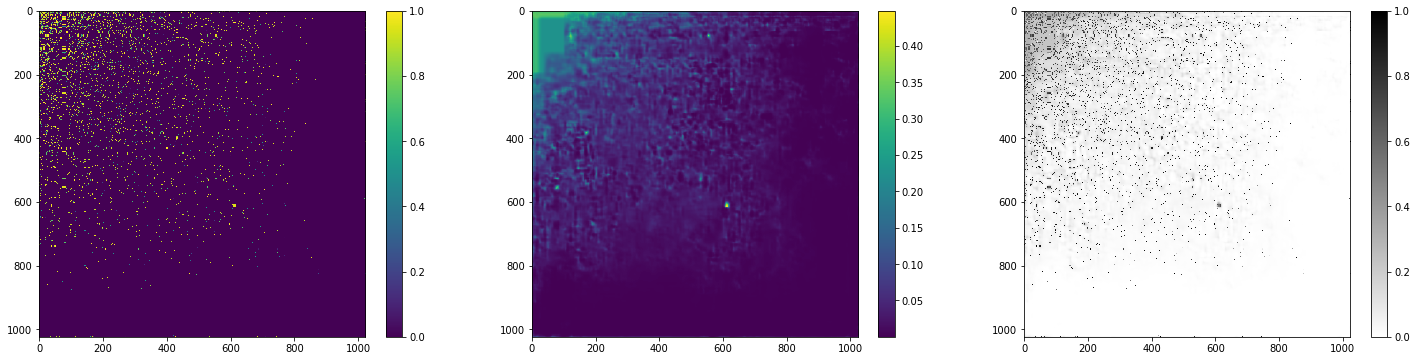

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_3_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


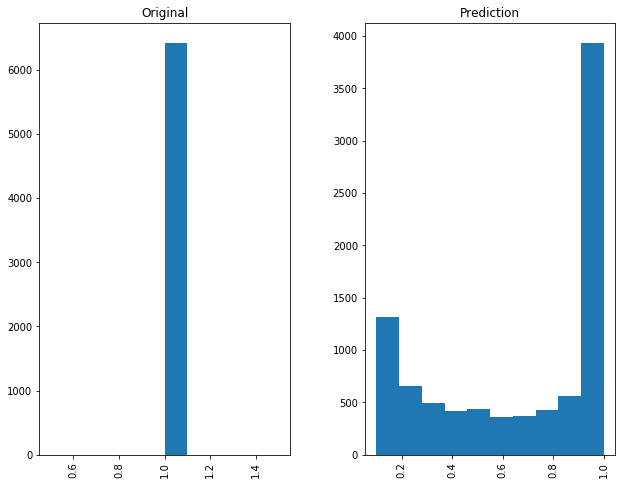

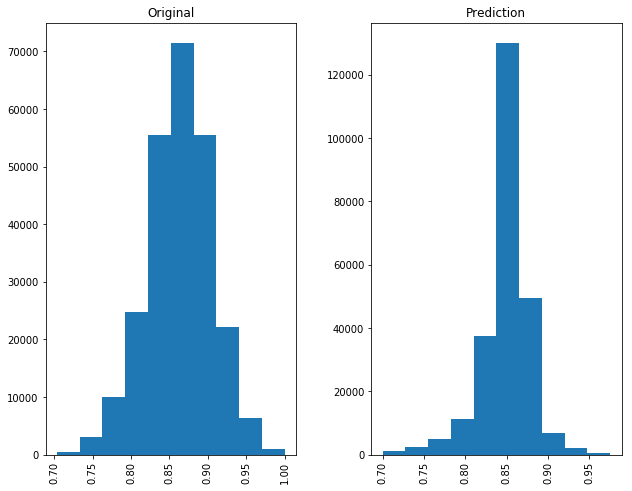

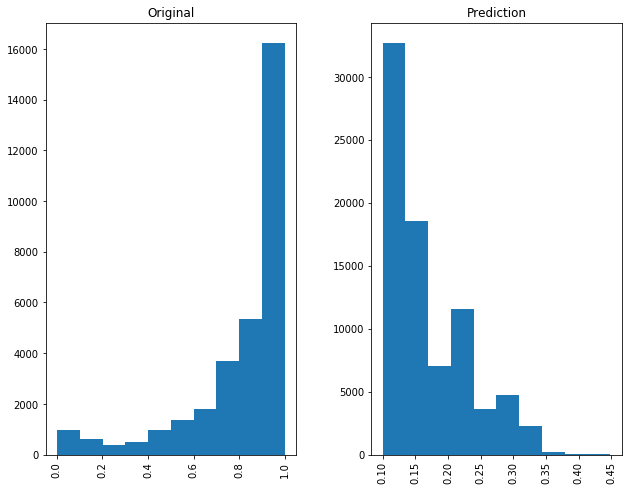

In [18]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_3_histogram_distribution_' + str(i))
    

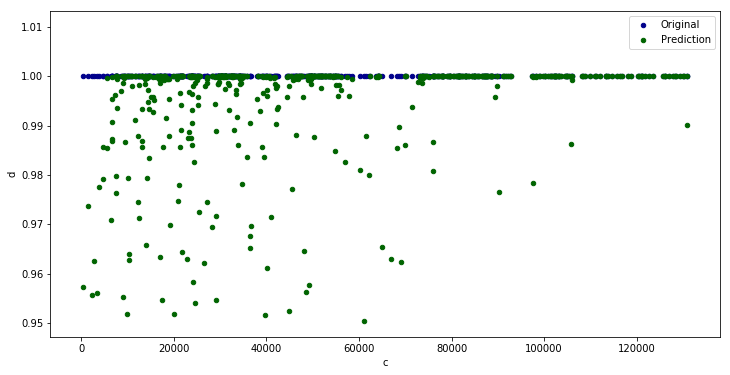

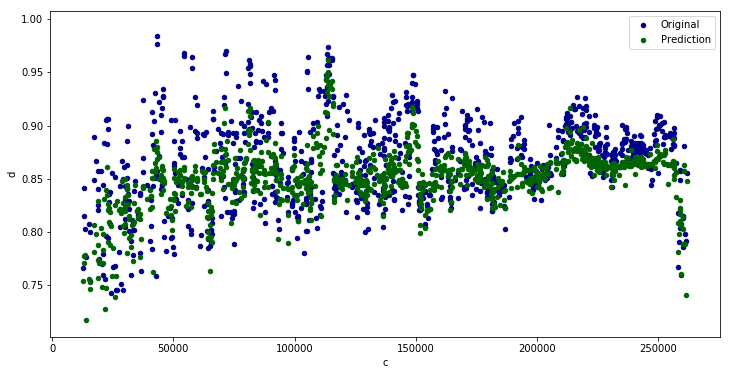

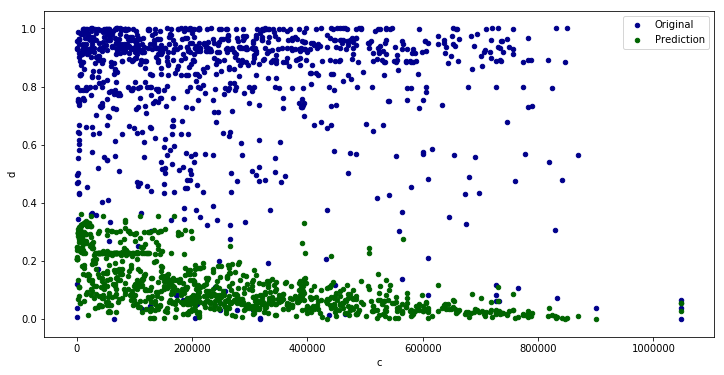

In [19]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

In [20]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.2326% 	8.96682% 	0.04888		0.04619		0.0		1.0	
(1024,256) 	95.4% 		0.46004% 	6.42129% 	0.82382		0.83052		0.0		0.98705	
(1024,1024) 	3.04% 		1.85077% 	2.32045% 	0.02452		0.00362		0.0		0.95211	


In [21]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.92316 0.90379 0.01937 	(688427, 0.938751472320377) 0.01368 0.93875 0.92507 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.90712 0.89420 0.01292 	(4240, 0.9623085983510011) 0.24800 0.96231 0.71431 	
(2436, 1.0) 0.98931 1.00000 0.01069 	(44828, 0.8401417658060423) 0.87922 0.84014 0.03908 	(694929, 0.9799764428739693) 0.02246 0.97998 0.95752 	
(55808, 1.0) 0.99647 1.00000 0.00353 	(232148, 0.8783613613364569) 0.88275 0.87836 0.00439 	(600540, 0.5747938751472321) 0.02171 0.57479 0.55309 	
(44159, 1.0) 0.99868 1.00000 0.00132 	(106790, 0.8420843224691953) 0.89155 0.84208 0.04947 	(226406, 0.8680800942285042) 0.07576 0.86808 0.79232 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.84106 0.82200 0.01907 	(122896, 0.99528857

(6926, 1.0) 0.98069 1.00000 0.01931 	(41727, 0.8431126758477174) 0.81029 0.84311 0.03282 	(311445, 0.9670200235571261) 0.03770 0.96702 0.92932 	
(75907, 1.0) 1.00000 1.00000 0.00000 	(128738, 0.8907939275311966) 0.85575 0.89079 0.03504 	(478600, 0.9528857479387515) 0.02298 0.95289 0.92991 	
(49659, 1.0) 1.00000 1.00000 0.00000 	(45049, 0.8941921952489368) 0.88064 0.89419 0.01356 	(1053, 0.7997644287396938) 0.26923 0.79976 0.53053 	
(1921, 1.0) 0.58188 1.00000 0.41812 	(19331, 0.7751304321123971) 0.80819 0.77513 0.03306 	(69727, 0.9187279151943463) 0.21107 0.91873 0.70766 	
(83203, 1.0) 1.00000 1.00000 0.00000 	(137038, 0.9067975246968422) 0.86215 0.90680 0.04465 	(134243, 0.9599528857479388) 0.17424 0.95995 0.78571 	
(1412, 1.0) 0.57847 1.00000 0.42153 	(230832, 0.8657114302948561) 0.88422 0.86571 0.01851 	(168119, 0.4369846878680802) 0.09498 0.43698 0.34200 	
(69505, 1.0) 0.96680 1.00000 0.03320 	(131760, 0.8853994675194621) 0.86578 0.88540 0.01962 	(26889, 0.833922261484099) 0.09504 

(88706, 1.0) 1.00000 1.00000 0.00000 	(241612, 0.8768043755984459) 0.88626 0.87680 0.00946 	(79093, 0.8881036513545347) 0.04680 0.88810 0.84130 	
(7579, 1.0) 0.99976 1.00000 0.00024 	(25242, 0.7675573019314136) 0.81164 0.76756 0.04408 	(484601, 0.568904593639576) 0.01430 0.56890 0.55460 	
(46591, 1.0) 1.00000 1.00000 0.00000 	(75072, 0.8197714824987464) 0.87124 0.81977 0.05147 	(593006, 0.9988221436984688) 0.04658 0.99882 0.95224 	
(69510, 1.0) 0.99670 1.00000 0.00330 	(201969, 0.8519213326274235) 0.85681 0.85192 0.00489 	(214035, 0.795053003533569) 0.16920 0.79505 0.62585 	
(104576, 1.0) 1.00000 1.00000 0.00000 	(144387, 0.8451563176955528) 0.87625 0.84516 0.03109 	(18502, 0.9116607773851589) 0.34966 0.91166 0.56200 	
(97664, 1.0) 1.00000 1.00000 0.00000 	(252561, 0.9032751260514961) 0.89907 0.90328 0.00421 	(196927, 1.0) 0.03824 1.00000 0.96176 	
(1922, 1.0) 0.63622 1.00000 0.36378 	(256716, 0.8929296810236506) 0.90281 0.89293 0.00988 	(11464, 0.7891637220259129) 0.16062 0.78916 0.62

(38528, 1.0) 0.99977 1.00000 0.00023 	(164759, 0.8273343462034536) 0.87586 0.82733 0.04853 	(673513, 0.43109540636042415) 0.01152 0.43110 0.41958 	
(7423, 1.0) 1.00000 1.00000 0.00000 	(213803, 0.9091971276268878) 0.92320 0.90920 0.01401 	(205036, 0.8433451118963486) 0.04706 0.84335 0.79629 	
(6538, 1.0) 0.98027 1.00000 0.01973 	(22814, 0.8825255394190613) 0.90515 0.88253 0.02263 	(755803, 0.9293286219081272) 0.02726 0.92933 0.90207 	
(5898, 1.0) 0.74759 1.00000 0.25241 	(139660, 0.9163537121668187) 0.89287 0.91635 0.02348 	(727081, 0.11778563015312142) 0.03940 0.11779 0.07839 	
(22524, 1.0) 1.00000 1.00000 0.00000 	(70870, 0.9194061700759756) 0.88775 0.91941 0.03165 	(385181, 0.9976442873969376) 0.19034 0.99764 0.80730 	
(15386, 1.0) 0.98422 1.00000 0.01578 	(113532, 0.9668285208641165) 0.97340 0.96683 0.00657 	(86570, 0.9458186101295644) 0.64936 0.94582 0.29646 	
(18839, 1.0) 1.00000 1.00000 0.00000 	(249210, 0.8965609206348729) 0.90432 0.89656 0.00776 	(181253, 0.8386336866902238) 0

(28192, 1.0) 0.94306 1.00000 0.05694 	(73728, 0.9040452110579724) 0.84886 0.90405 0.05518 	(345121, 0.8280329799764429) 0.13655 0.82803 0.69149 	
(259, 1.0) 0.55927 1.00000 0.44073 	(17314, 0.8490419367832586) 0.82294 0.84904 0.02610 	(264331, 0.7938751472320377) 0.12743 0.79388 0.66645 	
(23840, 1.0) 1.00000 1.00000 0.00000 	(110662, 0.8246079183182803) 0.86785 0.82461 0.04325 	(65695, 0.8621908127208481) 0.17065 0.86219 0.69154 	
(6412, 1.0) 0.85166 1.00000 0.14834 	(186516, 0.8439424305762835) 0.85344 0.84394 0.00950 	(241865, 0.8433451118963486) 0.11921 0.84335 0.72414 	
(55549, 1.0) 0.99998 1.00000 0.00002 	(204265, 0.8575250081535581) 0.87907 0.85753 0.02154 	(95592, 0.7891637220259129) 0.09105 0.78916 0.69812 	
(35761, 1.0) 0.98677 1.00000 0.01323 	(118222, 0.8354585627815965) 0.86354 0.83546 0.02808 	(193718, 0.8386336866902238) 0.04508 0.83863 0.79355 	
(120449, 1.0) 1.00000 1.00000 0.00000 	(158086, 0.8650159570861832) 0.87668 0.86502 0.01166 	(135704, 0.751472320376914) 0.02

(11519, 1.0) 1.00000 1.00000 0.00000 	(13034, 0.8413900033969399) 0.84380 0.84139 0.00241 	(67857, 0.8150765606595995) 0.07543 0.81508 0.73964 	
(23935, 1.0) 1.00000 1.00000 0.00000 	(63884, 0.8006484402889107) 0.85478 0.80065 0.05413 	(202904, 0.9717314487632509) 0.05761 0.97173 0.91412 	
(6805, 1.0) 0.99998 1.00000 0.00002 	(86122, 0.9020849701069771) 0.89732 0.90208 0.00477 	(66985, 0.9976442873969376) 0.10157 0.99764 0.89607 	
(29450, 1.0) 1.00000 1.00000 0.00000 	(224228, 0.8935522396243347) 0.88890 0.89355 0.00466 	(170542, 0.8457008244994111) 0.02181 0.84570 0.82389 	
(29573, 1.0) 1.00000 1.00000 0.00000 	(102549, 0.8758860878860674) 0.87580 0.87589 0.00009 	(27093, 0.5759717314487633) 0.09006 0.57597 0.48591 	
(21787, 1.0) 0.99914 1.00000 0.00086 	(153666, 0.8046045106434835) 0.83644 0.80460 0.03184 	(162092, 0.9799764428739693) 0.17066 0.97998 0.80932 	
(4743, 1.0) 0.75731 1.00000 0.24269 	(234933, 0.8784704154918971) 0.88419 0.87847 0.00572 	(145806, 0.9422850412249706) 0.263

(78208, 1.0) 1.00000 1.00000 0.00000 	(181594, 0.8313319908016144) 0.85280 0.83133 0.02147 	(11483, 0.8833922261484101) 0.08389 0.88339 0.79951 	
(11008, 1.0) 1.00000 1.00000 0.00000 	(226981, 0.8566625346847325) 0.88398 0.85666 0.02732 	(24576, 0.36277974087161374) 0.36538 0.36278 0.00260 	
(33027, 1.0) 1.00000 1.00000 0.00000 	(132801, 0.837351558643188) 0.87828 0.83735 0.04093 	(27879, 0.9693757361601885) 0.09768 0.96938 0.87169 	
(54399, 1.0) 1.00000 1.00000 0.00000 	(105223, 0.9507155518998696) 0.90574 0.95072 0.04497 	(12310, 0.9269729093050648) 0.36758 0.92697 0.55939 	
(49788, 1.0) 1.00000 1.00000 0.00000 	(243271, 0.8815957416991071) 0.88972 0.88160 0.00812 	(4654, 0.7550058892815077) 0.07495 0.75501 0.68006 	
(39168, 1.0) 1.00000 1.00000 0.00000 	(33440, 0.8023720092390346) 0.82828 0.80237 0.02591 	(141312, 0.7856301531213193) 0.35937 0.78563 0.42626 	
(32253, 1.0) 1.00000 1.00000 0.00000 	(71295, 0.832156820606386) 0.92525 0.83216 0.09309 	(108, 0.46760895170789174) 0.20493 

(25415, 1.0) 0.99948 1.00000 0.00052 	(175409, 0.9156561570916643) 0.87296 0.91566 0.04270 	(199688, 0.9988221436984688) 0.25779 0.99882 0.74103 	
(3204, 1.0) 0.71571 1.00000 0.28429 	(66930, 0.8611952742911493) 0.89988 0.86120 0.03868 	(82973, 0.9988221436984688) 0.22222 0.99882 0.77661 	
(258, 1.0) 0.65640 1.00000 0.34360 	(32418, 0.7914176499394617) 0.81625 0.79142 0.02483 	(374080, 0.9269729093050648) 0.01398 0.92697 0.91299 	
(87300, 1.0) 1.00000 1.00000 0.00000 	(231712, 0.8740718142169187) 0.89303 0.87407 0.01896 	(181452, 0.6383981154299176) 0.05973 0.63840 0.57867 	
(1694, 1.0) 0.06819 1.00000 0.93181 	(28015, 0.8047441309420261) 0.83566 0.80474 0.03092 	(609111, 0.2096584216725559) 0.00020 0.20966 0.20946 	
(7261, 1.0) 1.00000 1.00000 0.00000 	(194768, 0.8829893599177296) 0.87805 0.88299 0.00494 	(546928, 1.0) 0.04811 1.00000 0.95189 	
(39812, 1.0) 1.00000 1.00000 0.00000 	(113550, 0.9360737343211221) 0.95051 0.93607 0.01443 	(581374, 0.9163722025912839) 0.00662 0.91637 0.909

(50429, 1.0) 1.00000 1.00000 0.00000 	(15641, 0.7642865099690954) 0.73406 0.76429 0.03023 	(66671, 0.5606595995288576) 0.08566 0.56066 0.47500 	
(894, 1.0) 0.79204 1.00000 0.20796 	(107744, 0.9028633700131656) 0.90478 0.90286 0.00192 	(10381, 0.7597173144876326) 0.20323 0.75972 0.55649 	
(27010, 1.0) 1.00000 1.00000 0.00000 	(249679, 0.9103282201142535) 0.91164 0.91033 0.00131 	(54474, 0.9988221436984688) 0.08433 0.99882 0.91450 	
(19206, 1.0) 0.99871 1.00000 0.00129 	(30238, 0.8125795508208419) 0.82883 0.81258 0.01625 	(83067, 0.9988221436984688) 0.62123 0.99882 0.37759 	
(24449, 1.0) 0.93795 1.00000 0.06205 	(65989, 0.8085392306592272) 0.84024 0.80854 0.03170 	(12653, 0.9988221436984688) 0.22649 0.99882 0.77233 	
(29952, 1.0) 1.00000 1.00000 0.00000 	(114239, 0.9571151205014997) 0.96454 0.95712 0.00742 	(298101, 0.7444051825677268) 0.11251 0.74441 0.63189 	
(56772, 1.0) 0.99998 1.00000 0.00002 	(186877, 0.8227595891327615) 0.87734 0.82276 0.05459 	(2086, 0.4711425206124853) 0.34128 0

(23933, 1.0) 1.00000 1.00000 0.00000 	(80816, 0.9030846030421451) 0.91076 0.90308 0.00768 	(284072, 0.607773851590106) 0.07612 0.60777 0.53165 	
(30217, 1.0) 1.00000 1.00000 0.00000 	(106923, 0.8655341740792468) 0.87018 0.86553 0.00465 	(263549, 0.8610129564193169) 0.03782 0.86101 0.82319 	
(12312, 1.0) 0.98902 1.00000 0.01098 	(82893, 0.846706987997984) 0.86427 0.84671 0.01756 	(162270, 0.5830388692579506) 0.04715 0.58304 0.53588 	
(96000, 1.0) 0.96430 1.00000 0.03570 	(50334, 0.8616879761348447) 0.88836 0.86169 0.02668 	(16444, 0.7997644287396938) 0.36083 0.79976 0.43894 	
(81922, 1.0) 1.00000 1.00000 0.00000 	(193476, 0.872621784916784) 0.87923 0.87262 0.00661 	(112693, 0.9269729093050648) 0.21107 0.92697 0.71590 	
(49149, 1.0) 1.00000 1.00000 0.00000 	(240502, 0.8790242303596649) 0.88521 0.87902 0.00618 	(745491, 0.9623085983510011) 0.01885 0.96231 0.94346 	
(13842, 1.0) 0.97117 1.00000 0.02883 	(164925, 0.8802151530982744) 0.87694 0.88022 0.00327 	(787920, 0.8916372202591284) 0.00

(42162, 1.0) 1.00000 1.00000 0.00000 	(90847, 0.8432994664435706) 0.89682 0.84330 0.05352 	(70712, 0.850412249705536) 0.21107 0.85041 0.63934 	
(83204, 1.0) 1.00000 1.00000 0.00000 	(158730, 0.898673972958837) 0.88445 0.89867 0.01423 	(110617, 0.36395759717314485) 0.24773 0.36396 0.11623 	
(37135, 1.0) 0.99729 1.00000 0.00271 	(37354, 0.8564350625269722) 0.86918 0.85644 0.01275 	(262379, 0.9740871613663132) 0.09772 0.97409 0.87637 	
(56576, 1.0) 0.97924 1.00000 0.02076 	(63691, 0.8264761295751925) 0.87039 0.82648 0.04392 	(182510, 0.9623085983510011) 0.07544 0.96231 0.88687 	
(11535, 1.0) 0.94250 1.00000 0.05750 	(104566, 0.828796432830408) 0.88042 0.82880 0.05163 	(748775, 0.9352179034157833) 0.01135 0.93522 0.92387 	
(16901, 1.0) 1.00000 1.00000 0.00000 	(20866, 0.7798445033965178) 0.83661 0.77984 0.05677 	(321743, 0.9988221436984688) 0.04664 0.99882 0.95218 	
(4733, 1.0) 1.00000 1.00000 0.00000 	(205697, 0.8540255774062032) 0.86873 0.85403 0.01471 	(66629, 0.856301531213192) 0.21107

(99715, 1.0) 1.00000 1.00000 0.00000 	(200745, 0.8483918456663478) 0.85467 0.84839 0.00628 	(248105, 0.030624263839811604) 0.07057 0.03062 0.03995 	
(43147, 1.0) 0.97987 1.00000 0.02013 	(125345, 0.8300222673180879) 0.88452 0.83002 0.05450 	(555414, 0.8928150765606597) 0.02418 0.89282 0.86863 	
(32765, 1.0) 1.00000 1.00000 0.00000 	(135210, 0.873705502921109) 0.85214 0.87371 0.02156 	(541509, 0.42873969375736165) 0.00243 0.42874 0.42631 	
(90241, 1.0) 0.99873 1.00000 0.00127 	(194010, 0.8804331137897115) 0.87557 0.88043 0.00486 	(398349, 1.0) 0.20509 1.00000 0.79491 	
(37523, 1.0) 0.99880 1.00000 0.00120 	(61109, 0.7868409449316737) 0.86127 0.78684 0.07443 	(14356, 0.9305064782096585) 0.36790 0.93051 0.56261 	
(10762, 1.0) 0.95741 1.00000 0.04259 	(201932, 0.8593538414148431) 0.87685 0.85935 0.01750 	(91146, 0.6631330977620731) 0.29895 0.66313 0.36418 	
(1428, 1.0) 0.07013 1.00000 0.92987 	(105666, 0.9342314165231781) 0.89158 0.93423 0.04266 	(356858, 0.8833922261484101) 0.02419 0.8833

(84992, 1.0) 1.00000 1.00000 0.00000 	(120778, 0.8490222885068348) 0.86021 0.84902 0.01119 	(774707, 0.8857479387514724) 0.01032 0.88575 0.87543 	
(33808, 1.0) 1.00000 1.00000 0.00000 	(15309, 0.8080613765671922) 0.76868 0.80806 0.03938 	(209007, 0.054181389870435887) 0.09817 0.05418 0.04399 	
(38179, 1.0) 0.99571 1.00000 0.00429 	(51938, 0.827125906877109) 0.88588 0.82713 0.05875 	(286125, 0.9316843345111897) 0.04543 0.93168 0.88625 	
(102274, 1.0) 1.00000 1.00000 0.00000 	(137617, 0.8628610214921857) 0.87084 0.86286 0.00798 	(61450, 0.9811542991755006) 0.29895 0.98115 0.68220 	
(5392, 1.0) 0.99150 1.00000 0.00850 	(197187, 0.8470523818999868) 0.88027 0.84705 0.03322 	(290936, 0.9328621908127209) 0.10750 0.93286 0.82536 	
(104962, 1.0) 1.00000 1.00000 0.00000 	(225463, 0.877316005352627) 0.88184 0.87732 0.00452 	(417879, 0.9481743227326267) 0.03966 0.94817 0.90852 	
(13070, 1.0) 1.00000 1.00000 0.00000 	(231701, 0.869472777810849) 0.87097 0.86947 0.00150 	(588273, 0.8869257950530036) 

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


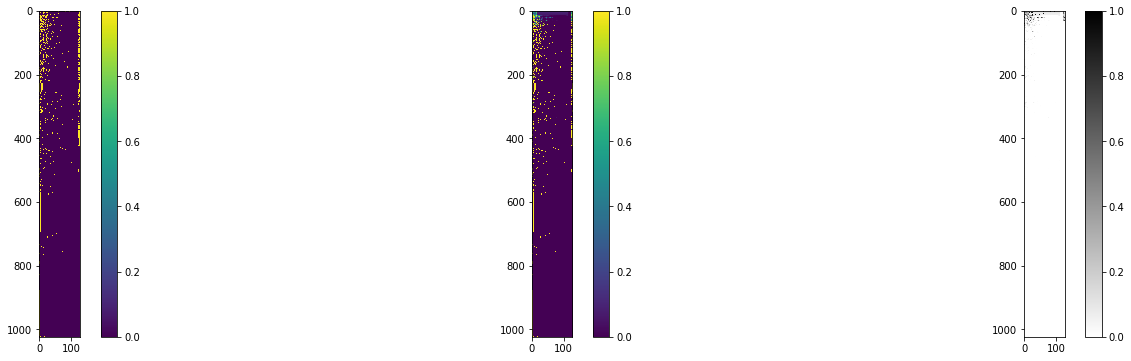

1.5581634e-08
0.987053


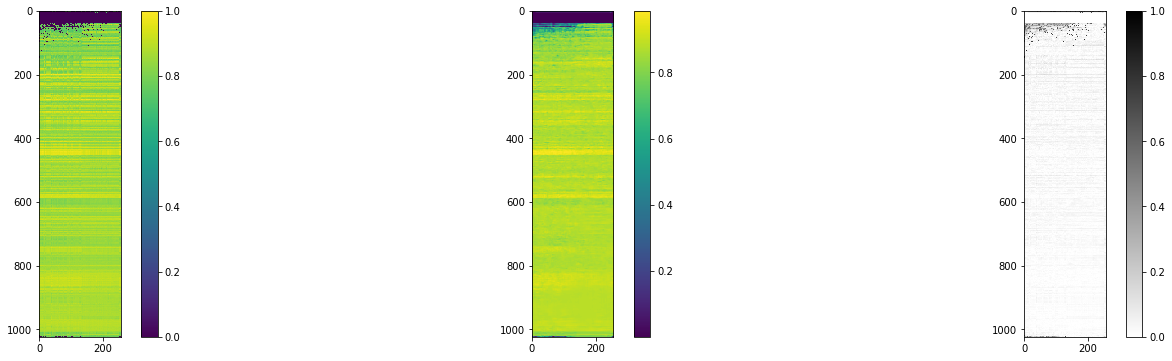

8.839596e-15
0.95211154


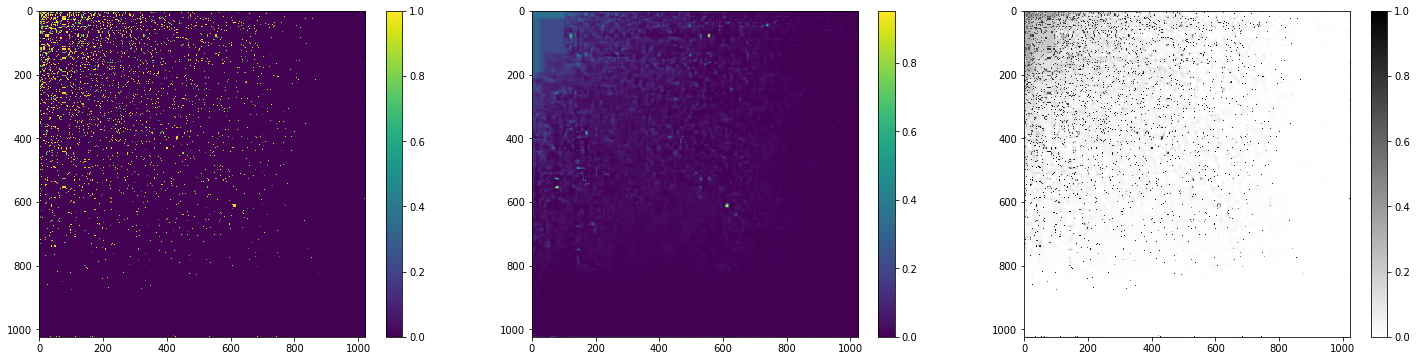

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_4_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


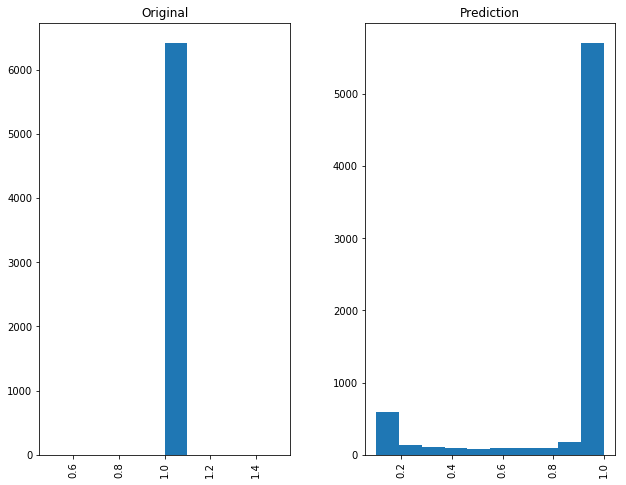

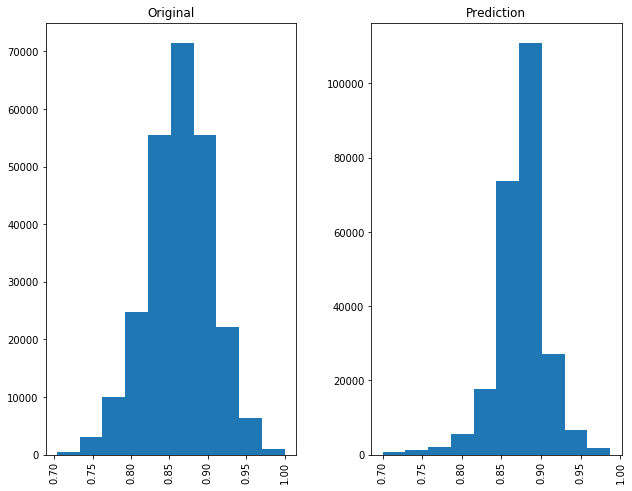

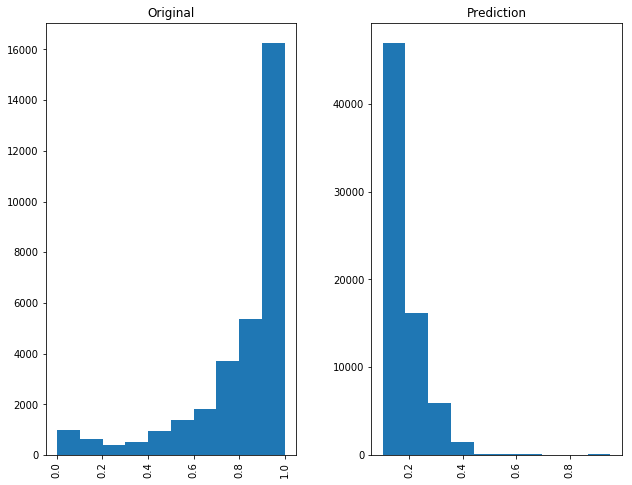

In [23]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_4_histogram_distribution_' + str(i))
    

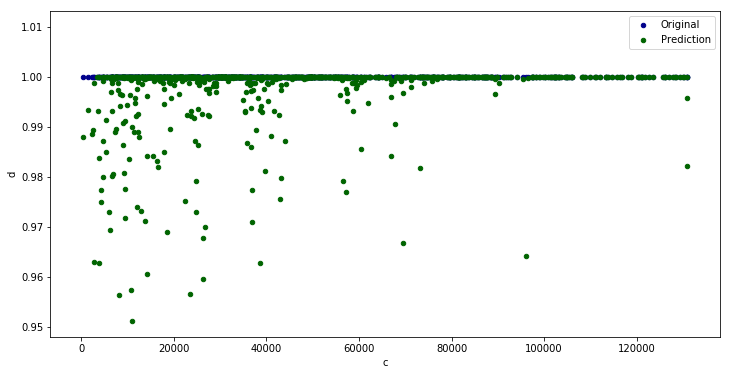

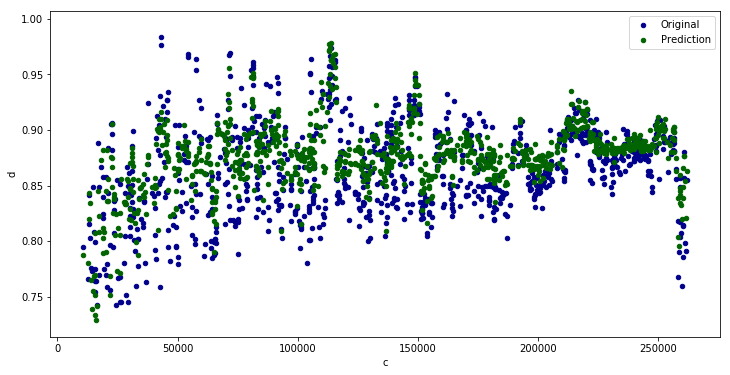

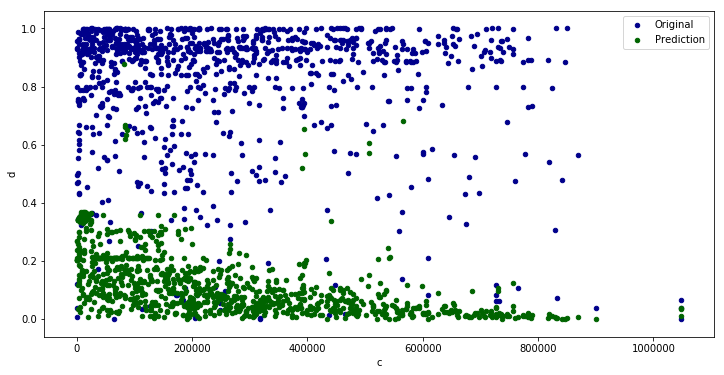

In [24]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));